# Michał Matak - SVM do mapowania obiektu



### Importowanie bibliotek
* numpy - operacje na macierzach 
* scipy - optymalizacja parametryczna
* matplotlib - tworzenie wykresów

In [2]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint
from data_operations import get_data, split_into_classes, split_into_sets, get_dictionary_axes
from data_operations import test, create_heatmap, create_classification_heatmap, calculate_precision, calculate_recall, create_class_heatmap
import matplotlib.pyplot as plt
import random

In [3]:
def encode(number, data_dictionary):
    vector = -np.ones(len(data_dictionary))
    vector[number-1] = 1
    return vector

def decode(vector):
    return np.argmax(vector) + 1

In [4]:
def make_3D_set(index, data):
    data_set = np.array([[row[0][0], row[0][1], row[0][2], row[1][index]] for row in data])
    return data_set

### Dekodowanie

In [5]:
data, data_dictionary = get_data("series4", encode)

In [6]:
x = encode(2, data_dictionary)
print(x)
print(decode(x))

[-1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
2


### Funkcje związane z SVM

Funkcja realizująca SVM **linear_SVM** przyjmuje jako argument zbiór z elementami postaci \[atrybuty, przynależność (1 lub -1) do danej klasy\] i zwraca **w** oraz **b** wyznaczające hiperpłaszczyznę dzielącą zbiór.  
Zmiennymi globalnymi są **TRAIN_SET**, **RECORD_SIZE** oraz **LAMBDA**, oznaczające odpowiednio wielkość podanego zbioru, ilość atrybutów dla elementu w zbiorze oraz $\lambda$. Zmienne te są globalne aby nie było potrzeby przekazywania ich jako parametry, do funkcji, która będzie minimalizowana (uznawała by je ona za zmienne i według nich szukała minimum).
Funkcja minimize zaimportowana z biblioteki SciPy wykorzystuje poniżej zdefiniowane funkcje **constraint** oraz **target**.

In [7]:
def linear_SVM(train_set):
    global TRAIN_SET
    global RECORD_SIZE
    global LAMBDA
    LAMBDA = 0.5
    TRAIN_SET = train_set
    RECORD_SIZE = len(TRAIN_SET[0]) - 1
    constraint = NonlinearConstraint(constraint1, np.zeros(len(TRAIN_SET)), np.inf)
    res = minimize(target, np.random.random(RECORD_SIZE + 1), constraints=constraint)
    w = res.x[:RECORD_SIZE]
    b = res.x[RECORD_SIZE]
    return w, b

Funkcja **target** jest równoważna:  

<center>$\sum_i\zeta_i + \lambda \|w\|$</center>
  
      
    
  
która jest minimalizowana dla argumentów *w* i *b* przez **minimize**. Argumenty te są zebrane w jednej liście aby funkcja optymalizująca mogła działać. 

In [8]:
def target(w):
    return np.linalg.norm(w[:RECORD_SIZE], 2)*LAMBDA + dzeta(w).sum()

Na minimalizację powyższej funkcji nałożone są warunki:  
<center>$y_i(w^Tx - b)\geq 1 - \zeta_i$ </center>  
Co jest równoważne:  
<center>$y_i(w^Tx - b) - 1 + \zeta_i\geq 0 $ </center>  
Operacja ta w funkcji constarint jest wykonywana od razu dla całej macierzy, gdzie $\zeta$ jest obliczane od razu jako wektor.

In [9]:
def constraint1(w):
    return ((np.matmul(TRAIN_SET[:, :RECORD_SIZE], w[:RECORD_SIZE]) - w[RECORD_SIZE]) * TRAIN_SET[:, RECORD_SIZE]) + \
            dzeta(w) - np.ones(len(TRAIN_SET))

Funkcja **dzeta** wykonuje operację:
<center>$\zeta_i = max(1 - f(x_i)y_i, 0)$</center>  
dla każdego elementu macierzy z danymi i zwraca wynik jako wektor.


In [10]:
def dzeta(w):
    return np.maximum(np.zeros(len(TRAIN_SET)), np.ones(len(TRAIN_SET)) - ((np.matmul(TRAIN_SET[:, :RECORD_SIZE], w[:RECORD_SIZE]) - w[RECORD_SIZE]) * TRAIN_SET[:, RECORD_SIZE]))

### Uczenie SVM - program

Dane są ładowane do listy data, następnie tworzony jest zbiór testowy, który zostaje podzielony na 3 grupy. Uczone są 3 SVM (porównują zbiory 1 z 2, 2 z 3 i 3 z 1), które zwracają parametry *w* i *b* a ich wyniki są przekazywane do funkcji **predict**.

In [11]:
def train_svm(data_dictionary, class_vector):
    parameters_array = [[[] for _ in range (len(data_dictionary))] for _ in range (len(data_dictionary))] 
    for i in range (len(data_dictionary)):
        for j in range (len(data_dictionary)):
            if i!=j:
                parameters_array[i][j] = linear_SVM(make_3D_set(i, class_vector[i] + class_vector[j]))
    return parameters_array

#### Funkcja predict

Funkcja **predict** przyjmuje jako argument atrybuty elementu zbioru i na ich podstawie decyduje do jakiej klasy należy dany element. Robi to instrukcjami warunkowymi (jeśli widzi, że dla porównań 1 z 2 i 1 z 3 oba wskazania są na 1 to zwraca macierz odpowiadającą elementowi klasy pierwszej, analogicznie dla pozostałych zbiorów). Sytuację, w której porówniane 1 z 2 wskazuje na 2, 2 z 3 na 2 i 3 z 1 na 1 pozostawiłem nierozstrzygnięte. Porównania między dwoma klasami odbywają się za pomocą obliczenia $wx - b$ i zwrócenia 1 jeśli wynik jest większy niż 0 lub -1 jeśli mniejszy.

Funkcja progowa unipolarna zwraca 1 jeśli *x* jest większy lub równy *a* i -1 jeśli *x* jest mniejszy od *a*  

In [12]:
def threshold_unipolar_function(x, a):
    if (x >= a):
        return 1
    elif (x < a):
        return -1

In [13]:
def predict(element, parameters_array):
    for i in range (len(data_dictionary)):
        pred_vector = [(threshold_unipolar_function(np.matmul(parameters_array[i][j][0], element) - parameters_array[i][j][1], 0)) 
                       for j in range(len(data_dictionary)) if i!=j]
#         print(pred_vector)
        if pred_vector == list(np.ones(len(data_dictionary)-1)):
            return i+1
    return 0

### Ewaluacja - sprawdzenie działania algorytmu

Poniżej znajduje się fragment programu, który sprawdza stopień poprawnośći przewidywań przez SVM. Zbiór testowy jest podzielony na 3 klasy i dla każdej klasy przewidywana jest jej klasa na podstawie modelu. Jeśli model się pomylił dodawana jest jedynka do liczby błędów.

In [17]:
data, data_dictionary = get_data("series4", encode)
train_set, test_set = split_into_sets(0.9, data)
class_vector = split_into_classes(data, data_dictionary, decode)

In [18]:
parameters_array = train_svm(data_dictionary, class_vector)

In [19]:
classes_vector = split_into_classes(test_set, data_dictionary, decode)
total_errors = 0
for element in data_dictionary.values():
    errors = 0
    for row in classes_vector[element-1]:
        if predict(row[0], parameters_array) != element:
            errors += 1
    total_errors += errors
    print(f"Class {element}: accuracy {(1 - errors/len(classes_vector[element-1]))*100:.2f}%")
total_accuracy = (1 - (total_errors)/(len(test_set)))*100
print(f"Total accuracy {total_accuracy:.2f}%")

Class 1: accuracy 100.00%
Class 2: accuracy 100.00%
Class 3: accuracy 88.75%
Class 4: accuracy 98.02%
Class 5: accuracy 0.00%
Class 6: accuracy 100.00%
Class 7: accuracy 0.00%
Class 8: accuracy 0.00%
Class 9: accuracy 100.00%
Class 10: accuracy 100.00%
Class 11: accuracy 100.00%
Class 12: accuracy 80.22%
Class 13: accuracy 100.00%
Class 14: accuracy 64.37%
Class 15: accuracy 0.00%
Class 16: accuracy 100.00%
Class 17: accuracy 100.00%
Class 18: accuracy 100.00%
Class 19: accuracy 100.00%
Class 20: accuracy 100.00%
Class 21: accuracy 0.00%
Class 22: accuracy 100.00%
Class 23: accuracy 100.00%
Class 24: accuracy 100.00%
Class 25: accuracy 0.00%
Class 26: accuracy 100.00%
Class 27: accuracy 100.00%
Class 28: accuracy 0.00%
Class 29: accuracy 100.00%
Class 30: accuracy 0.00%
Class 31: accuracy 100.00%
Class 32: accuracy 100.00%
Class 33: accuracy 0.00%
Class 34: accuracy 100.00%
Class 35: accuracy 0.00%
Total accuracy 69.03%


In [20]:
"""
Sample test
"""
for _ in range(10):
    x = random.choice(data)
    print(decode(x[1]), predict(x[0], parameters_array))
    


22 22
20 20
11 11
33 0
21 0
31 31
5 0
31 31
17 17
9 9


In [21]:
classification_array = test(class_vector, predict, [parameters_array])

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444


297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546


415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664


557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806


713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962


827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103

942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218

75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
3

201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450


309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558


426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675


545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794


654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903


783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
4

903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
32
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179

24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292


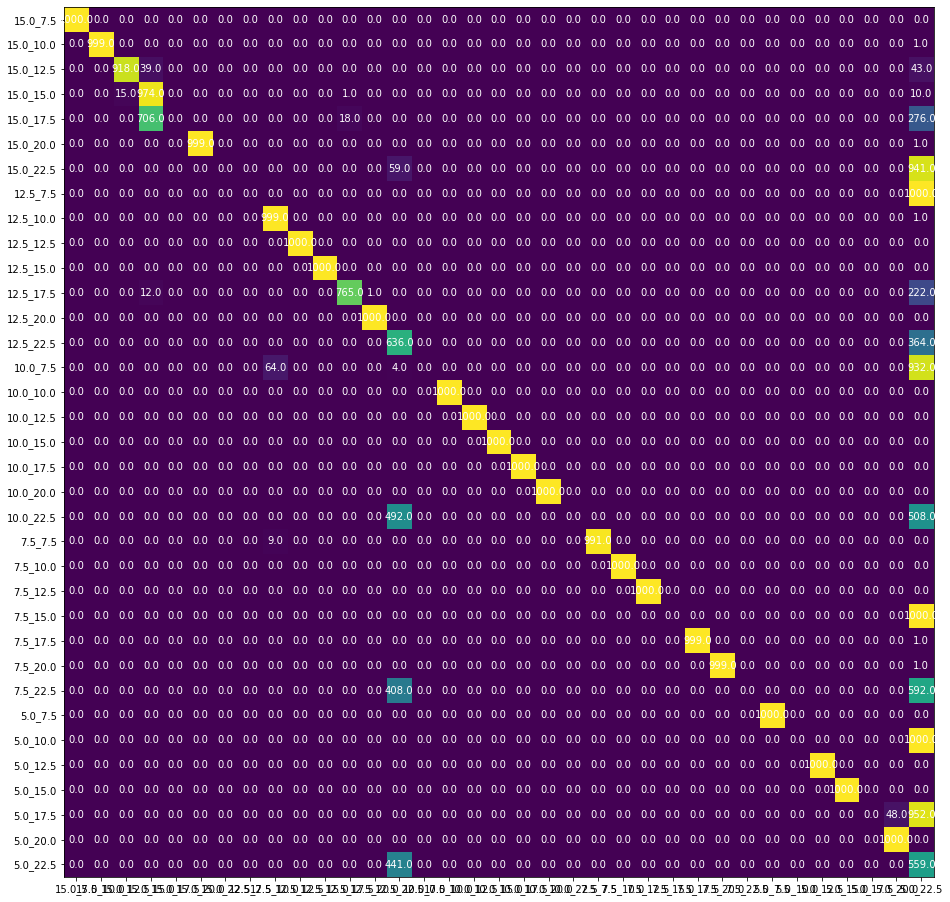

In [22]:
create_classification_heatmap(classification_array, data_dictionary)

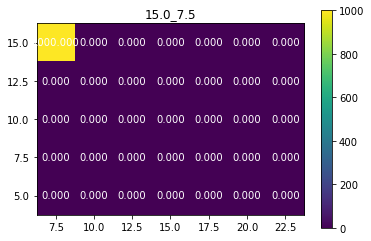

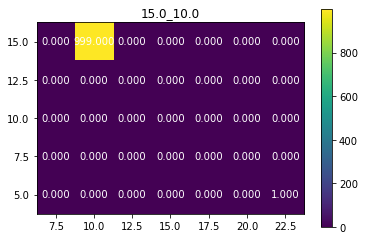

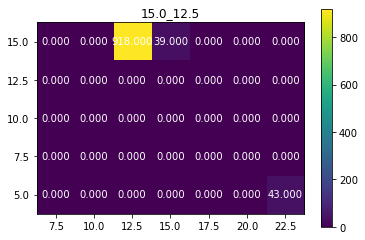

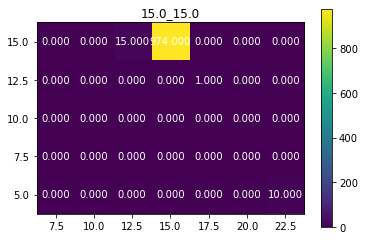

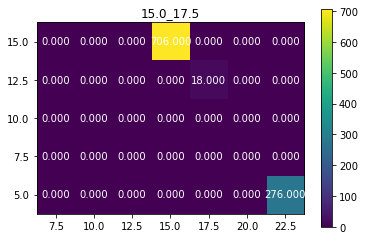

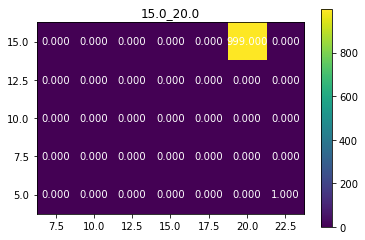

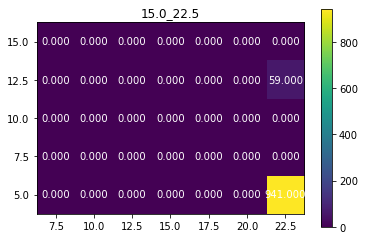

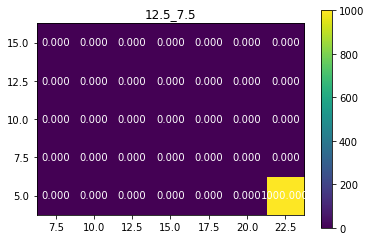

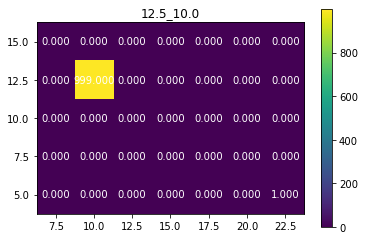

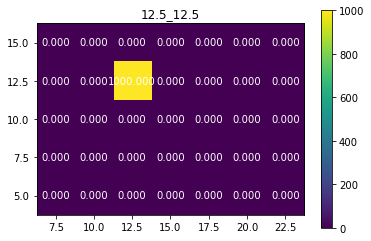

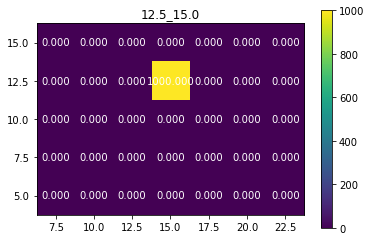

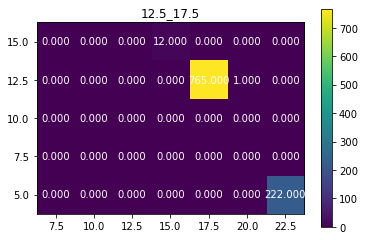

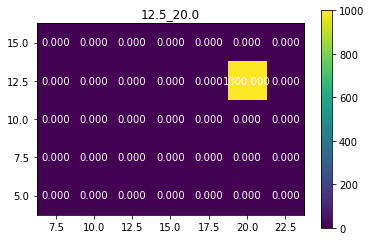

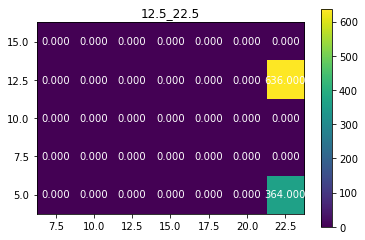

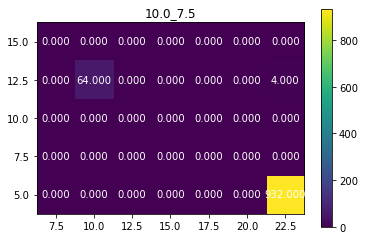

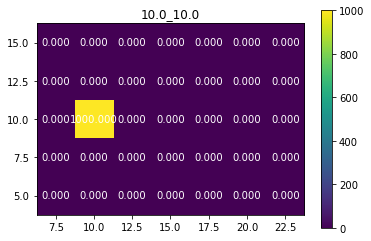

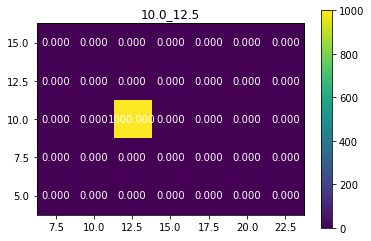

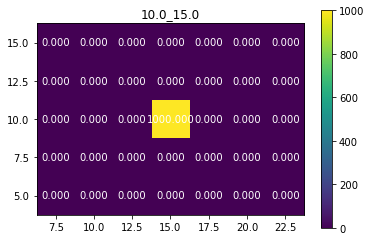

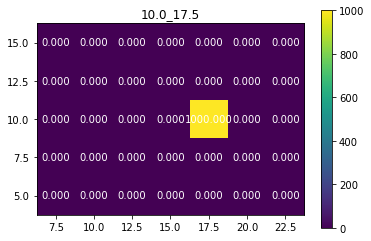

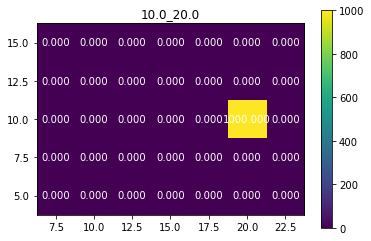

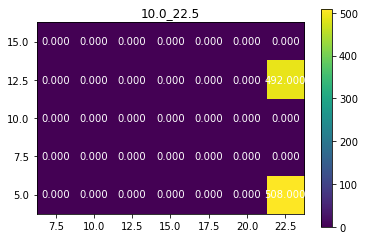

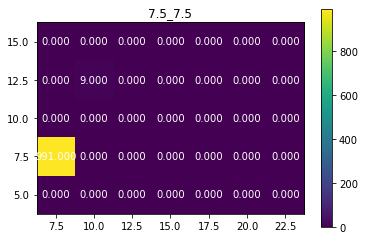

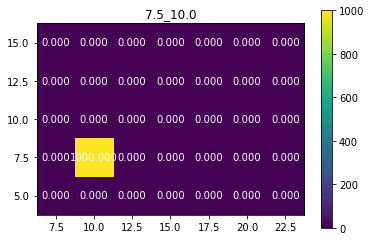

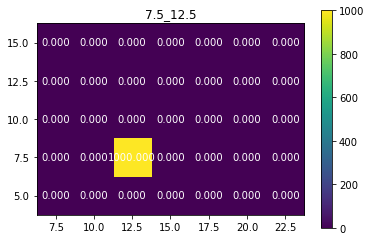

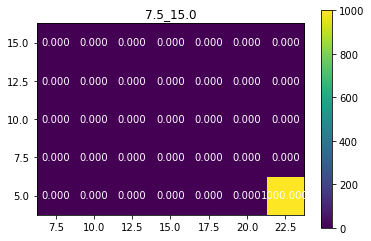

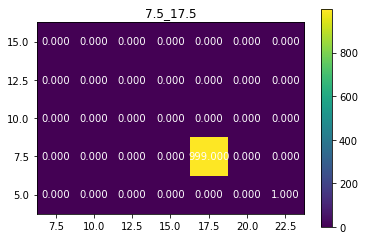

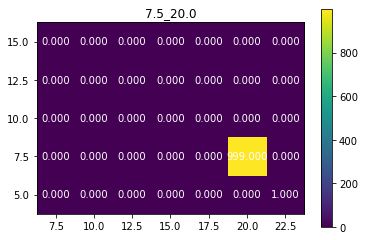

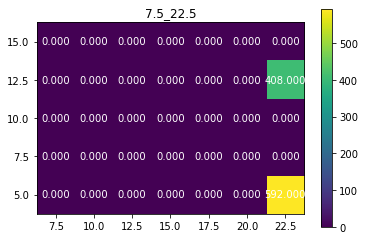

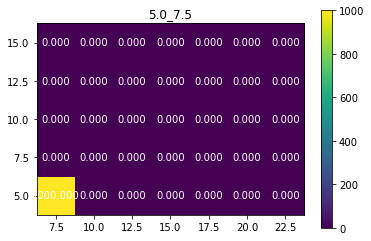

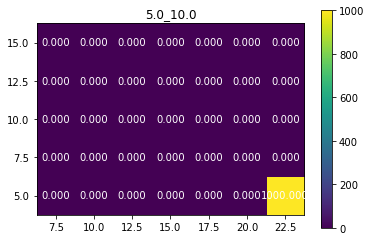

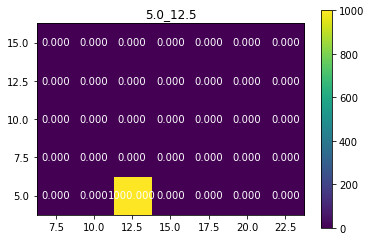

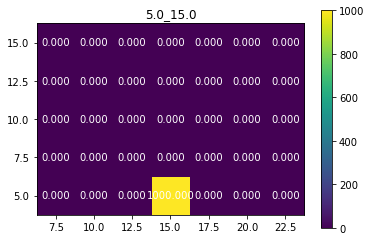

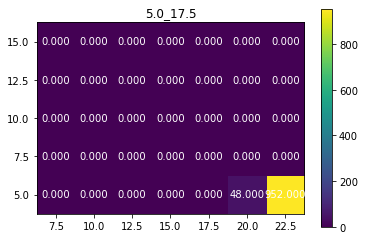

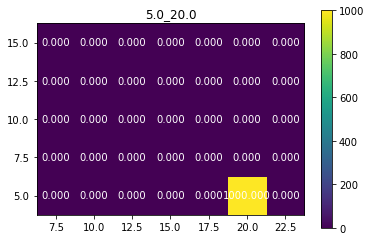

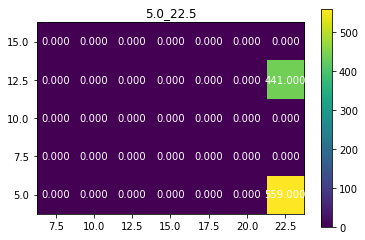

In [24]:
for class_name in data_dictionary:
    create_class_heatmap(class_name, data_dictionary, classification_array)


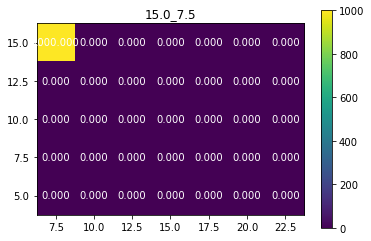

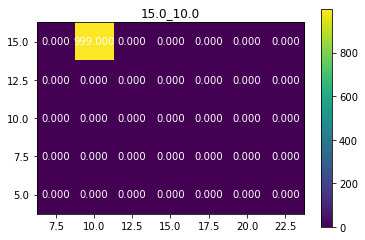

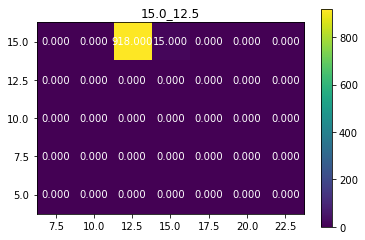

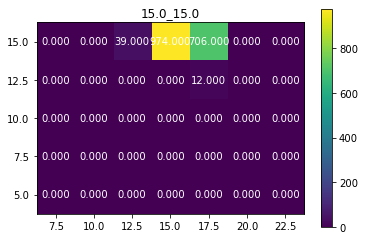

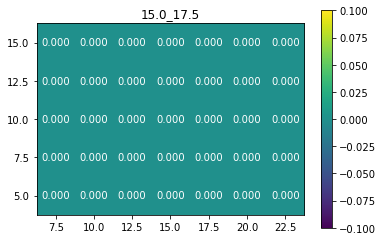

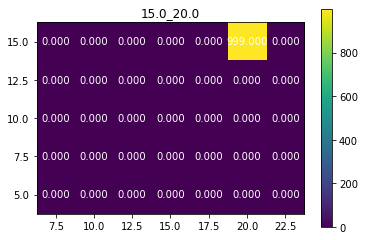

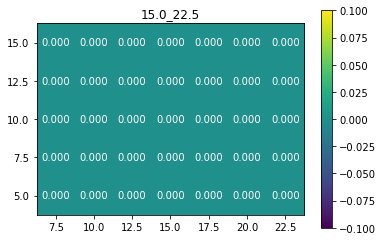

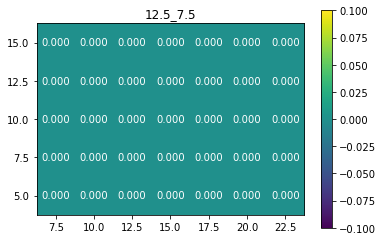

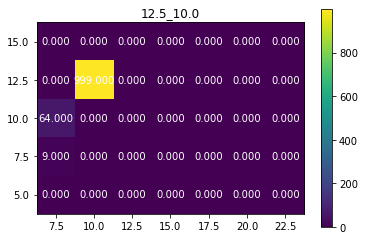

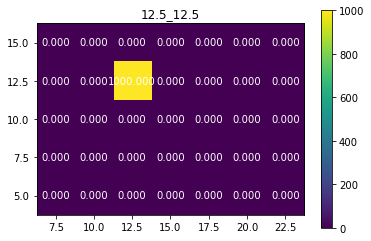

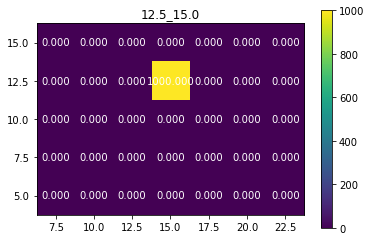

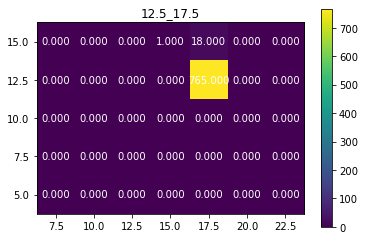

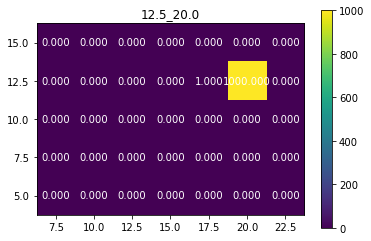

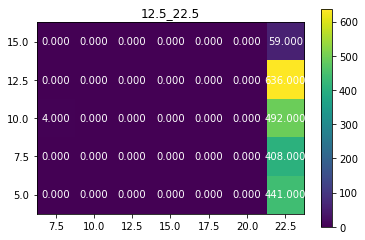

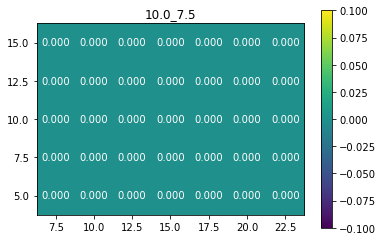

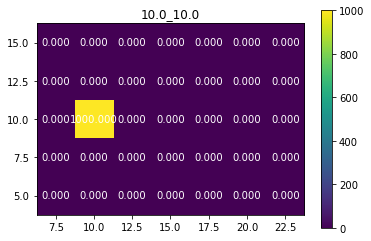

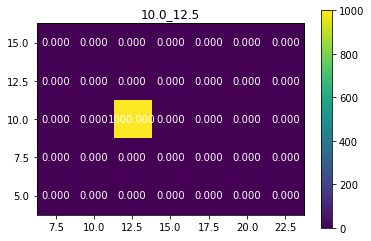

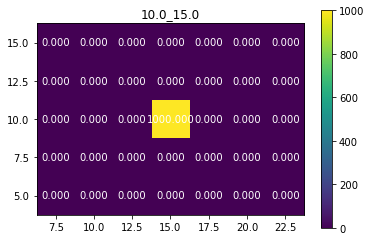

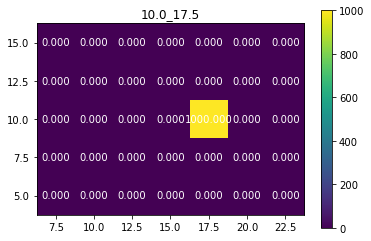

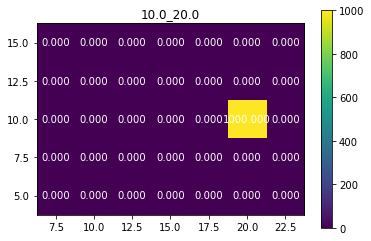

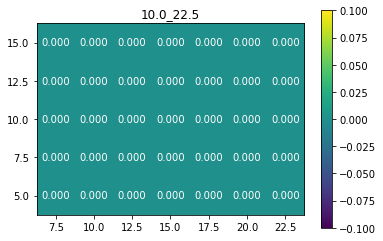

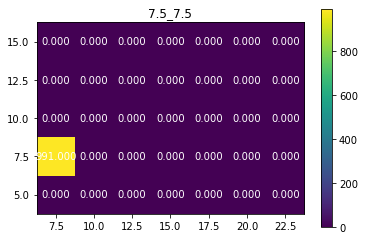

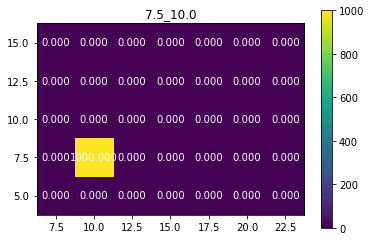

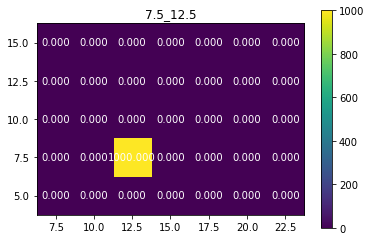

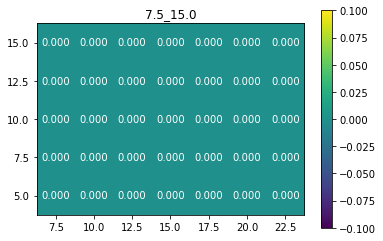

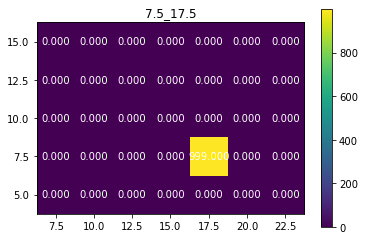

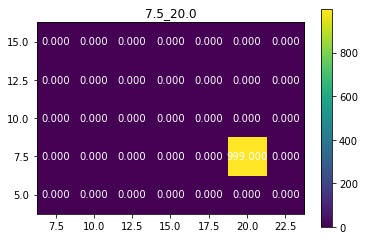

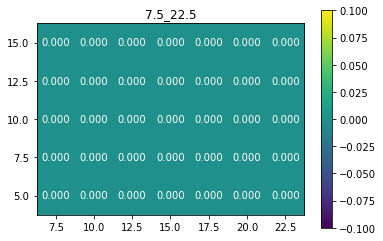

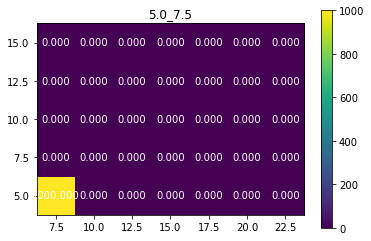

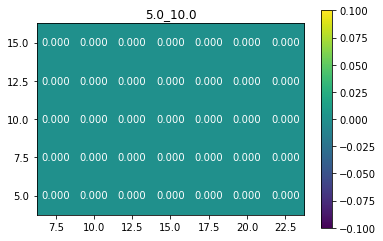

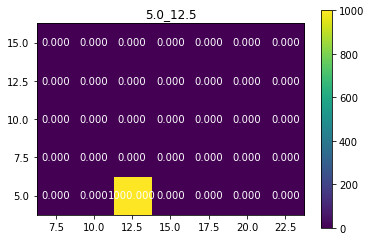

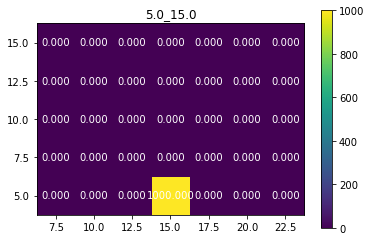

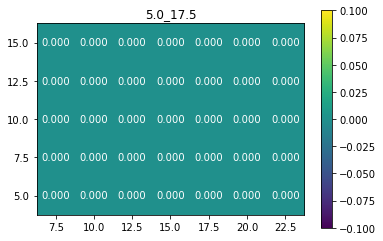

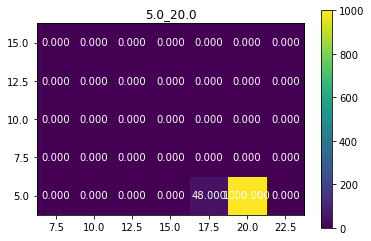

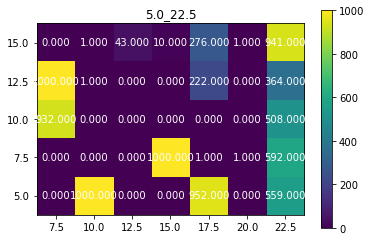

In [25]:
for class_name in data_dictionary:
    create_class_heatmap(class_name, data_dictionary, classification_array, True)

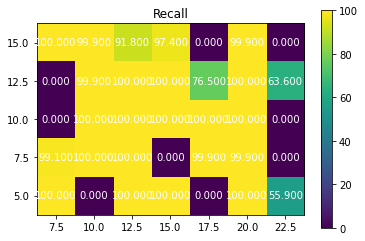

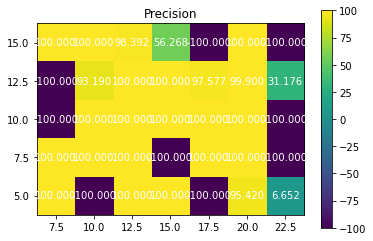

In [26]:
create_heatmap("Recall", data_dictionary, calculate_recall(classification_array))
create_heatmap("Precision", data_dictionary, calculate_precision(classification_array))